In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import re
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt


### Clear day-ahead load

In [2]:
# Specify the directory you want to use
directory = './DAM/Load'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [3]:
values = ['CA ISO-TAC', 'MWD-TAC', 'PGE-TAC','SCE-TAC','SDGE-TAC','VEA-TAC']
df_selected = combined_df[combined_df['TAC_AREA_NAME'].isin(values)]
df_sorted = df_selected.sort_values(by=['OPR_DT', 'OPR_HR',]).reset_index(drop=True)

In [4]:
CAISO = df_sorted[df_sorted['TAC_AREA_NAME']=='CA ISO-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[24:8784].reset_index(drop=True)
Zone1 = df_sorted[df_sorted['TAC_AREA_NAME']=='PGE-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[24:8784].reset_index(drop=True)
Zone2_values = ['MWD-TAC','SCE-TAC','VEA-TAC']
Zone2_sep = df_sorted[df_sorted['TAC_AREA_NAME'].isin(Zone2_values)]
Zone2 = Zone2_sep.groupby(['INTERVALSTARTTIME_GMT'])['MW'].sum().iloc[24:8784].reset_index()
Zone3 = df_sorted[df_sorted['TAC_AREA_NAME']=='SDGE-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[24:8784].reset_index(drop=True)

In [5]:
train_pre = pd.concat([CAISO['INTERVALSTARTTIME_GMT'], CAISO['MW'], Zone1['MW'], Zone2['MW'], Zone3['MW']], axis=1)
train_pre.columns = ['INTERVALSTARTTIME_GMT', 'CAISO', 'Zone1', 'Zone2', 'Zone3']
train_pre['CAISO'] = train_pre[['Zone1', 'Zone2', 'Zone3']].sum(axis=1)
train_pre['INTERVALSTARTTIME_GMT'] = pd.to_datetime(train_pre['INTERVALSTARTTIME_GMT'])
train_pre.set_index('INTERVALSTARTTIME_GMT', inplace=True)

In [6]:
train_pre

,CAISO,Zone1,Zone2,Zone3
INTERVALSTARTTIME_GMT,,,,
2022-01-01 08:00:00+00:00,22630.73,10247.46,10307.27,2076.0
2022-01-01 09:00:00+00:00,21765.85,9876.01,9899.84,1990.0
2022-01-01 10:00:00+00:00,21104.63,9598.49,9587.14,1919.0
2022-01-01 11:00:00+00:00,20740.12,9453.62,9417.50,1869.0
2022-01-01 12:00:00+00:00,20710.33,9498.25,9353.08,1859.0
...,...,...,...,...
2023-01-01 03:00:00+00:00,25297.50,11625.42,11119.08,2553.0
2023-01-01 04:00:00+00:00,24463.21,11225.39,10761.82,2476.0
2023-01-01 05:00:00+00:00,23822.35,10897.86,10500.49,2424.0


In [7]:
DAMLoad = train_pre.resample('5T').ffill()

In [8]:
train_pre['CAISO'].max()

51317.22

### K-Means training

In [9]:
reshaped_data = train_pre[['CAISO', 'Zone1', 'Zone2', 'Zone3']].values.reshape(-1, 24*4)/max(train_pre['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

kmeans = KMeans(n_clusters= 8, random_state=0).fit(reshaped_data)

labels = kmeans.labels_  # the label of the cluster each data point belongs to

/Users/ningkunzheng/opt/anaconda3/envs/STESTS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


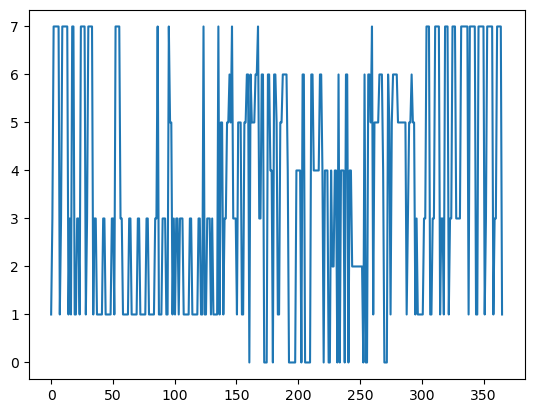

In [10]:
# Generate some data
x1 = np.linspace(0, 365, 365)
y1 = labels

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Show the plot
plt.show()

### Clear real-time load

In [11]:
# Specify the directory you want to use
directory = './RTD/Load'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [12]:
combined_df = combined_df.sort_values(by=['INTERVALSTARTTIME_GMT', 'TAC_AREA_NAME']).reset_index(drop=True)

In [13]:
combined_df

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,LOAD_TYPE,OPR_DT,OPR_HR,OPR_INTERVAL,MARKET_RUN_ID,TAC_AREA_NAME,LABEL,XML_DATA_ITEM,POS,MW,EXECUTION_TYPE,GROUP
0,2021-12-31T08:00:00-00:00,2021-12-31T08:05:00-00:00,0,2021-12-31,1,1,RTM,AZPS,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,2858.05,RTD,1
1,2021-12-31T08:00:00-00:00,2021-12-31T08:05:00-00:00,0,2021-12-31,1,1,RTM,BANC,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,1670.37,RTD,2
2,2021-12-31T08:00:00-00:00,2021-12-31T08:05:00-00:00,0,2021-12-31,1,1,RTM,BANCMID,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,240.14,RTD,3
3,2021-12-31T08:00:00-00:00,2021-12-31T08:05:00-00:00,0,2021-12-31,1,1,RTM,BANCRDNG,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,101.72,RTD,4
4,2021-12-31T08:00:00-00:00,2021-12-31T08:05:00-00:00,0,2021-12-31,1,1,RTM,BANCRSVL,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,109.24,RTD,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130566,2023-01-01T07:55:00-00:00,2023-01-01T08:00:00-00:00,0,2022-12-31,24,12,RTM,SRP,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,2676.27,RTD,926
3130567,2023-01-01T07:55:00-00:00,2023-01-01T08:00:00-00:00,0,2022-12-31,24,12,RTM,TEPC,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,1069.41,RTD,927
3130568,2023-01-01T07:55:00-00:00,2023-01-01T08:00:00-00:00,0,2022-12-31,24,12,RTM,TIDC,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,240.64,RTD,928
3130569,2023-01-01T07:55:00-00:00,2023-01-01T08:00:00-00:00,0,2022-12-31,24,12,RTM,TPWR,RTM 5Min Load Forecast,SYS_FCST_5MIN_MW,5.8,490.33,RTD,929


In [14]:
values = ['CA ISO-TAC', 'MWD-TAC', 'PGE-TAC','SCE-TAC','SDGE-TAC','VEA-TAC']
df_selected = combined_df[combined_df['TAC_AREA_NAME'].isin(values)]
df_selected = df_selected[df_selected['XML_DATA_ITEM']=='SYS_FCST_5MIN_MW'].reset_index(drop=True)[['INTERVALSTARTTIME_GMT', 'TAC_AREA_NAME', 'MW']]

In [15]:
df_selected['INTERVALSTARTTIME_GMT'] = pd.to_datetime(df_selected['INTERVALSTARTTIME_GMT'])
df_pivot = df_selected.pivot(index='INTERVALSTARTTIME_GMT', columns='TAC_AREA_NAME', values='MW')
df_resampled = df_pivot.resample('5T').asfreq()
df_interpolated = df_resampled.interpolate(method='linear')

In [16]:
CAISO = df_interpolated['CA ISO-TAC'][288:105397]
Zone1 = df_interpolated['PGE-TAC'][288:105397]
Zone2 = (df_interpolated['MWD-TAC']+df_interpolated['SCE-TAC']+df_interpolated['VEA-TAC'])[288:105397]
Zone3 = df_interpolated['SDGE-TAC'][288:105397]
RTDLoad = pd.concat([CAISO, Zone1, Zone2, Zone3], axis=1)
RTDLoad.columns = ['CAISO', 'Zone1', 'Zone2', 'Zone3']
RTDLoad['CAISO'] = RTDLoad[['Zone1', 'Zone2', 'Zone3']].sum(axis=1)


### RTD load noise

In [17]:
RTDLoadMAE = sum((abs((RTDLoad['CAISO'].values - DAMLoad['CAISO'].values))/RTDLoad['CAISO'].values))/105109

RTDLoadMAE

0.0750120335207664

In [18]:
RTDLoadNoise = (DAMLoad - RTDLoad)/max(DAMLoad['CAISO'])

In [19]:
RTDLoadNoise['CAISO'].max()

0.14039069146769848

In [20]:
### find closest date to each cluster centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reshaped_data)
noise_list = []
for i in closest:
    selected_rows = RTDLoadNoise.iloc[288*i:288*(i+1)].values
    noise_list.append(selected_rows)
noise_list = np.stack(noise_list)
# j = 0
# for i in closest:
#     selected_rows = RTDLoadNoise.loc[RTDLoadNoise.index.date == train_pre.index.date[24*i]]
#     selected_rows.to_csv(f"./noise/cluster_{j}.csv")
#     j=j+1

In [21]:
noise_list[:, :, 0].shape

(8, 288)

In [22]:
noise_list[:, :, 0].min()

-0.011969276589807397

### ADS day-ahead load prediction

In [23]:
ADSLoad = pd.read_csv("./Processed Data/2022/Load.csv")[['1','2','3']]
ADSLoad['CAISO'] = ADSLoad[['1', '2', '3']].sum(axis=1)
ADSLoad = ADSLoad[['CAISO', '1', '2', '3']]
reshaped_ADSLoad = ADSLoad.values.reshape(-1, 24*4)/max(ADSLoad['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

In [24]:
ADSLoad['CAISO'].max()/train_pre['CAISO'].max()

1.2262549101451716

In [25]:
ADSLoad['CAISO'].mean()/train_pre['CAISO'].mean()

1.4165691671861582

In [26]:
ADSLoad_C = pd.read_csv("./Processed Data/2022/Load.csv")

In [27]:
ADSLoad_C = ADSLoad_C.iloc[:,1:8]/(ADSLoad['CAISO'].max()/train_pre['CAISO'].max())
ADSLoad_C.to_csv('Processed Data/2022/Load_C.csv')

In [28]:
ADSLoad_C

,1,2,3,4,5,6
0,10560.134677,11487.856141,1603.255558,18480.659945,17909.816155,11461.781628
1,9764.093828,10636.344770,1484.193853,17656.198414,17459.665052,11169.835804
2,9174.450522,10130.918863,1350.453308,17299.013300,17400.134200,11037.726241
3,8817.452970,9767.682805,1240.362006,17174.243158,17454.772106,11066.268431
4,8744.054691,9627.255232,1204.480396,17429.491881,18157.725458,11302.760858
...,...,...,...,...,...,...
8779,15243.043551,16165.113661,2783.271220,21563.216409,23036.808877,15140.631729
8780,14946.561966,15979.703598,2733.526261,20970.354359,22496.138259,15200.162581
8781,14523.675178,15736.467059,2611.202592,20326.116368,21411.535059,15010.153148
8782,13795.956175,15126.602019,2457.074769,19408.688849,20483.506155,14484.161371


In [29]:
ADSLoadC = ADSLoad_C[['1','2','3']]
ADSLoadC['CAISO'] = ADSLoadC[['1', '2', '3']].sum(axis=1)
ADSLoadC = ADSLoadC[['CAISO', '1', '2', '3']]

/var/folders/f2/rxpbf6rd2wjbpqry4k3rs6fr0000gn/T/ipykernel_87639/1359669237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADSLoadC['CAISO'] = ADSLoadC[['1', '2', '3']].sum(axis=1)


In [30]:
reshaped_ADSLoad

array([[0.46088324, 0.2057815 , 0.22385967, ..., 0.22390465, 0.24455603,
        0.03650204],
       [0.45385911, 0.20068848, 0.22286616, ..., 0.22230719, 0.2421857 ,
        0.03774155],
       [0.45247412, 0.20139492, 0.21880421, ..., 0.22754926, 0.22025985,
        0.03550089],
       ...,
       [0.442139  , 0.19612003, 0.21234556, ..., 0.23688625, 0.26010888,
        0.04060196],
       [0.48440974, 0.21187809, 0.23812725, ..., 0.24415025, 0.26999463,
        0.04066553],
       [0.49644231, 0.21766192, 0.24458257, ..., 0.24703367, 0.27685707,
        0.04301742]])

In [31]:
predictions = kmeans.predict(reshaped_ADSLoad)
predictions

array([6, 6, 5, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, 6, 6, 5, 7, 6, 6, 6, 6,
       6, 7, 7, 6, 6, 6, 5, 6, 7, 1, 5, 5, 6, 6, 5, 7, 1, 5, 5, 5, 5, 5,
       7, 1, 5, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6, 7, 7, 6, 6, 5, 5, 5, 7,
       1, 5, 6, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 7, 7, 5, 5, 5, 6, 5, 7, 1,
       5, 5, 5, 5, 5, 5, 7, 6, 0, 6, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 5, 7, 7, 5, 5, 5, 6, 0, 6, 5, 0, 0, 0, 0, 6, 5, 7, 6, 6,
       6, 6, 6, 5, 7, 6, 6, 6, 6, 5, 7, 7, 6, 4, 0, 6, 0, 0, 0, 4, 0, 0,
       0, 4, 0, 6, 4, 2, 2, 4, 4, 6, 5, 0, 4, 4, 4, 2, 4, 0, 4, 4, 4, 4,
       4, 4, 6, 0, 0, 6, 0, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2,
       4, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2,
       4, 2, 4, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 0, 6, 0, 0, 4, 4, 4, 4, 0,
       4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 0, 0, 4, 4, 4, 4, 2, 4, 0, 4,
       4, 4, 2, 4, 6, 6, 4, 4, 0, 0, 0, 5, 5, 0, 0, 6, 6, 0, 5, 5, 6, 6,
       6, 6, 0, 6, 5, 6, 6, 0, 0, 0, 6, 5, 6, 6, 6,

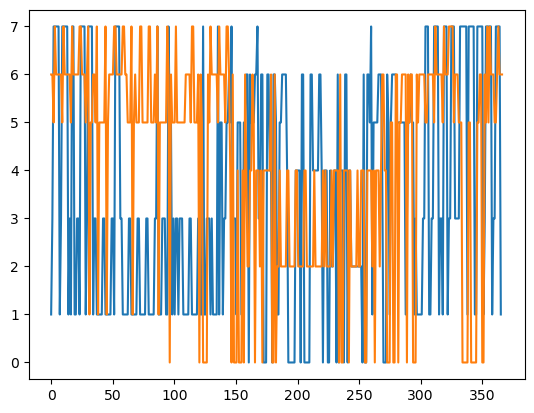

In [32]:
# Generate some data
x2 = np.linspace(0, 366, 366)
y2 = predictions

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Plot the data
ax.plot(x2, y2)

# Show the plot
plt.show()

### Apply noise to ADS load base on prediciton

In [33]:
ADSLoad['CAISO'].mean()

35579.44421083788

In [34]:
ADSLoadC['CAISO'].mean()

29014.721096305962

In [35]:
ADSLoad['CAISO'].mean()/ADSLoadC['CAISO'].mean()

1.2262549101451714

In [36]:
ADSLoad['CAISO'].max()/ADSLoadC['CAISO'].max()

1.2262549101451716

In [37]:
max(ADSLoad['CAISO'])

62927.993

In [38]:
noise_list_ADS = max(ADSLoad['CAISO'])*noise_list
noise_list_ADS[1]

array([[1221.17821482,  784.01833935,  488.55221875,  -51.39234328],
       [1309.14974207,  829.7085973 ,  529.20256902,  -49.76142425],
       [1394.44803362,  863.38155714,  577.49248738,  -46.4260109 ],
       ...,
       [2100.09642166, 1316.75252251,  757.15109427,   26.19280488],
       [2202.18214293, 1354.70511198,  812.29577758,   35.18125337],
       [2288.2468438 , 1384.31916806,  864.87758813,   39.05008761]])

In [39]:
noise_list_ADSC = max(ADSLoadC['CAISO'])*noise_list
noise_list_ADSC[1]

array([[ 995.86 ,  639.36 ,  398.41 ,  -41.91 ],
       [1067.6  ,  676.62 ,  431.56 ,  -40.58 ],
       [1137.16 ,  704.08 ,  470.94 ,  -37.86 ],
       ...,
       [1712.61 , 1073.8  ,  617.45 ,   21.36 ],
       [1795.86 , 1104.75 ,  662.42 ,   28.69 ],
       [1866.045, 1128.9  ,  705.3  ,   31.845]])

In [40]:
ADSLoad_repeated = ADSLoad.loc[ADSLoad.index.repeat(12)].reset_index(drop=True)

In [41]:
ADSLoadC_repeated = ADSLoadC.loc[ADSLoad.index.repeat(12)].reset_index(drop=True)

In [42]:
-noise_list_ADSC[predictions[0]]+ADSLoadC_repeated[0:288].values

array([[23028.49637631, 10078.77467744, 11296.36614105,  1653.35555782],
       [22929.13637631, 10039.79467744, 11242.15614105,  1647.18555782],
       [22824.75637631,  9997.58467744, 11189.10614105,  1638.06555782],
       ...,
       [24358.51257861, 10656.07398094, 11860.12547645,  1842.31312122],
       [24231.12257861, 10602.89398094, 11795.95547645,  1832.27312122],
       [24116.06257861, 10556.38398094, 11735.88547645,  1823.79312122]])

In [43]:
ADSRTDLoad = np.empty((0, 4))
for i in range(len(reshaped_ADSLoad)):
    adjust = -noise_list_ADS[predictions[i]]+ADSLoad_repeated[i*288:i*288+288].values
    ADSRTDLoad = np.vstack((ADSRTDLoad, adjust))

In [44]:
ADSRTDLoadC = np.empty((0, 4))
for i in range(len(reshaped_ADSLoad)):
    adjustC = -noise_list_ADSC[predictions[i]]+ADSLoadC_repeated[i*288:i*288+288].values
    ADSRTDLoadC = np.vstack((ADSRTDLoadC, adjustC))

In [45]:
len(ADSRTDLoadC)

105408

In [47]:
ADSLoad_rest = pd.read_csv("./Processed Data/2022/Load.csv")[['4','5','6']]
new_index = np.arange(ADSLoad_rest.index.min(), ADSLoad_rest.index.max() + 1, 1/12)
ADSLoad_rest_reindexed = ADSLoad_rest.reindex(new_index)
ADSLoad_rest_interpolated = ADSLoad_rest_reindexed.interpolate(method='linear')
ADSLoad_rest_interpolated.values

array([[22662.        , 21962.        , 14055.066     ],
       [22577.75      , 21916.        , 14025.23266667],
       [22493.5       , 21870.        , 13995.39933333],
       ...,
       [22392.        , 24105.        , 16984.274     ],
       [22392.        , 24105.        , 16984.274     ],
       [22392.        , 24105.        , 16984.274     ]])

In [48]:
ADSLoadC_rest = pd.read_csv("./Processed Data/2022/Load_C.csv")[['4','5','6']]
new_index = np.arange(ADSLoadC_rest.index.min(), ADSLoadC_rest.index.max() + 1, 1/12)
ADSLoadC_rest_reindexed = ADSLoadC_rest.reindex(new_index)
ADSLoadC_rest_interpolated = ADSLoadC_rest_reindexed.interpolate(method='linear')
ADSLoadC_rest_interpolated.values

array([[18480.65994477, 17909.81615511, 11461.78162772],
       [18411.95481723, 17872.30356322, 11437.45280906],
       [18343.24968969, 17834.79097132, 11413.12399041],
       ...,
       [18260.47734019, 19657.41364261, 13850.52476405],
       [18260.47734019, 19657.41364261, 13850.52476405],
       [18260.47734019, 19657.41364261, 13850.52476405]])

In [51]:
ADSLoad_RTD = np.hstack((ADSRTDLoad, ADSLoad_rest_interpolated))
np.savetxt("./Processed Data/2022/realtimeload_fixed.csv", ADSLoad_RTD, delimiter=",")


In [52]:
ADSLoadC_RTD = np.hstack((ADSRTDLoadC, ADSLoadC_rest_interpolated))
np.savetxt("./Processed Data/2022/realtimeload_C_fixed.csv", ADSLoadC_RTD, delimiter=",")

In [ ]:
ADSRTDLoadC

In [ ]:
df_interpolated

In [ ]:
ADSLoadC_rest_interpolated